In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
from numpy.random import choice
from scipy.optimize import curve_fit

In [4]:
import matplotlib.pyplot as plt
from plotting import initialize_plot_settings
initialize_plot_settings()

In [5]:
from disloc import deform_dislocation
from utils import load_and_mask_results, rotate

In [6]:
ORIGIN_X = 321660
ORIGIN_Y = 4164942

In [7]:
filename = f'results/sfm/strike_slip/HSLSurvey101419_utm_s310.00_d90.00_dep100.00_ss1.00_ds0.00_ICP_w50.00_str25.00.pkl'
x, y, ux, uy, uz, residual, mask = load_and_mask_results(filename, iterations=2)
xx, yy = np.meshgrid(x, y)

## Convenience functions

In [8]:
def rmse(ypred, yobs):
    return np.sqrt(np.nanmean((ypred - yobs) ** 2))

In [14]:
def center_profiles(uobs, utrue, dx=25):
    n = len(uobs)
    idx = np.where(uobs == np.sign(uobs) * np.min(np.abs(uobs)))[0][0]
    xp = np.arange(2*(n - idx), dtype=float)
    xp -= np.mean(xp)
    x = dx * xp - dx / 2
    if 2*idx - n < 0:
        return x[np.abs(2*idx - n)+1:], uobs[np.abs(2*idx - n):], utrue[np.abs(2*idx - n):]        
    return x, uobs[(2*idx - n):], utrue[(2*idx - n):]

In [15]:
def model_1d(x, depth, s):
    delta = 89.999
    deltarad = np.deg2rad(delta)
    zeta = (x / depth) - (1 / np.tan(deltarad))
    u1 = (s/np.pi)*(np.cos(deltarad)*np.arctan(zeta) + (np.sin(deltarad) - zeta*np.cos(deltarad))/(1+np.power(zeta,2)))
    u2 = (-s/np.pi)*(np.sin(deltarad)*np.arctan(zeta) + (np.cos(deltarad) + zeta*np.sin(deltarad))/(1+np.power(zeta,2)))
    return u2

In [9]:
def model_2d(depth, slip_ds, slip_ss, strike=310, dip=89.999, x=x, y=y, origin_x=ORIGIN_X, origin_y=ORIGIN_Y):
    if x.ndim < 2:
        x, y = np.meshgrid(x, y)
    x0 = np.mean(x) if origin_x is None else origin_x
    y0 = np.mean(y) if origin_y is None else origin_y

    xt = x - x0
    yt = y - y0

    deltarad = np.deg2rad(dip)
    thetarad = np.deg2rad(strike)
    X1p = xt * np.cos(np.pi - thetarad) + yt * np.sin(np.pi - thetarad)
    Zeta = (X1p / depth) - (1 / np.tan(deltarad))
    u1 = (slip_ds / np.pi) * (
        np.cos(deltarad) * np.arctan(Zeta)
        + (np.sin(deltarad) - Zeta * np.cos(deltarad)) / (1 + np.power(Zeta, 2))
    )
    u3 = (-slip_ds / np.pi) * (
        np.sin(deltarad) * np.arctan(Zeta)
        + (np.cos(deltarad) + Zeta * np.sin(deltarad)) / (1 + np.power(Zeta, 2))
    )
    u2 = (slip_ss / np.pi) * (
        np.arctan2(
            Zeta * np.power(np.sin(deltarad), 2),
            (1 - Zeta * np.sin(deltarad) * np.cos(deltarad)),
        )
        + (deltarad - np.sign(deltarad) * np.pi / 2.0)
    )

    u1p = u1 * np.cos(thetarad - np.pi) + u2 * np.sin(thetarad - np.pi)
    u2p = -u1 * np.sin(thetarad - np.pi) + u2 * np.cos(thetarad - np.pi)
    
    up, un = rotate(u1p, u2p, theta=50)
    
    return up, u3

## Bootstrap

In [718]:
def get_bootstrap_dists_1d(x, uobs, nboot=100, **kwargs):
    depths_b = []
    slips_b = []

    for i in range(nboot):
        idx = choice(range(len(uobs)), size=len(uobs), replace=True)
        xboot = xp[idx]
        uboot = uobsc[idx]
        phat, pcov = curve_fit(model_1d, xboot, uboot, **kwargs)
        depths_b.append(phat[0])
        slips_b.append(phat[1])
    
    return depths_b, slips_b

In [727]:
def plot_bootstrap_dists(depths_b, slips_b):
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))

    ax[0].hist(depths_b, bins=30, color='0.5', ec='w')
    ymin, ymax = ax[0].set_ylim()
    ax[0].vlines(np.nanmedian(depths_b), ymin, ymax, colors='r', linestyles='-')
    ax[0].vlines(np.nanpercentile(depths_b, [2.5, 97.5]), ymin, ymax, colors='k', linestyles='--')
    ax[0].set_xlabel('Depth [m]')
    ax[0].set_ylabel('Count')

    ax[1].hist(slips_b, bins=30, color='0.5', ec='w')
    ymin, ymax = ax[1].set_ylim()
    ax[1].vlines(np.nanmedian(slips_b), ymin, ymax, colors='r', linestyles='-')
    ax[1].vlines(np.nanpercentile(slips_b, [2.5, 97.5]), ymin, ymax, colors='k', linestyles='--')
    ax[1].set_xlabel('Slip [m]')
    ax[1].set_yticklabels([])
    
    hist, x, y, im = ax[2].hist2d(slips_b, depths_b, bins=20, density=True)
    dx = np.diff(x)[0]
    dy = np.diff(y)[0]
    ax[2].clear()
    c = ax[2].contour(x[1:] - dx, y[1:] - dy, hist, levels=[0.1, 0.5, 1], colors='k', linestyles='-')
    ax[2].clabel(c, fmt='%2.1f', colors='k', fontsize=14)
    ax[2].set_xlabel('Slip [m]')
    ax[2].set_ylabel('Depth [m]')

## Dip slip

In [728]:
us = np.load('profiles/lidar_ds_applied.npy', allow_pickle=True)

In [729]:
uicps = np.load('profiles/lidar_ds_observed.npy', allow_pickle=True)

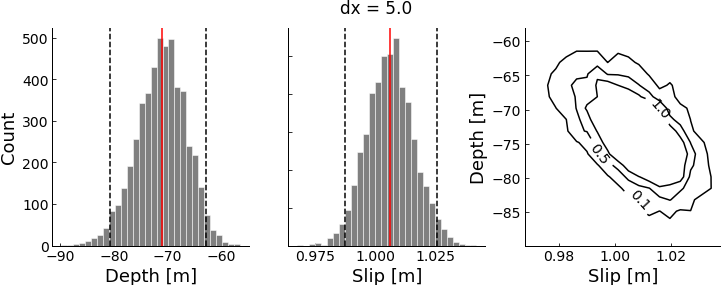

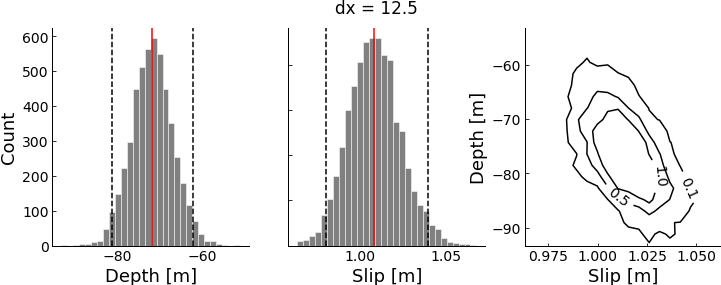

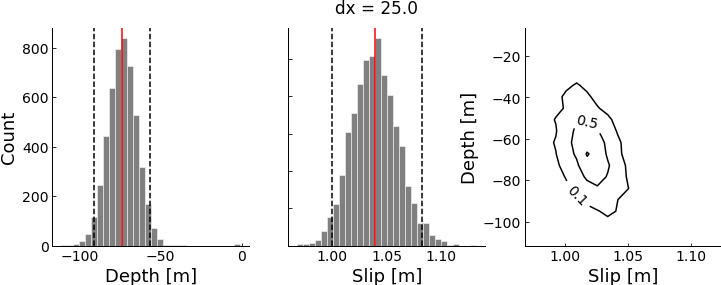

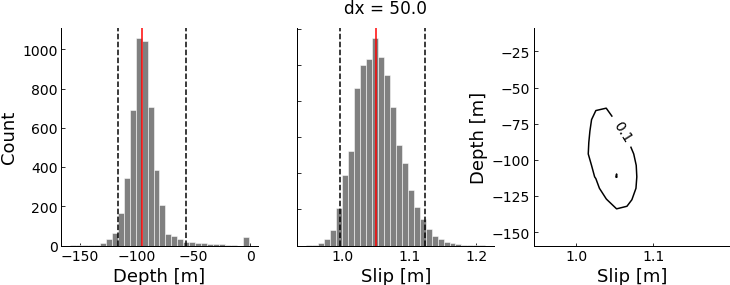

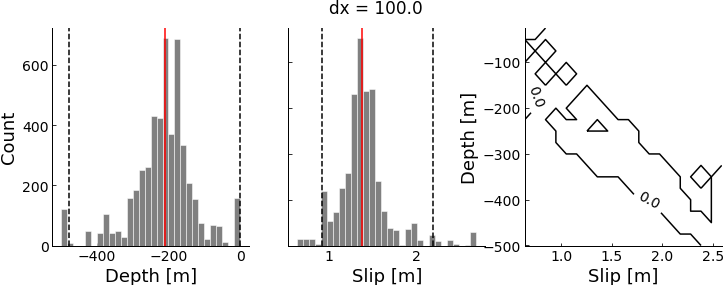

In [730]:
median_depths = []
median_slips = []
upper_depths = []
upper_slips = []
lower_depths = []
lower_slips = []

for uobs, utrue, dx in zip(uicps, us, dxs):
    xp, uobsc, utruec = center_profiles(uobs, utrue, dx=dx)
    depths_b, slips_b = get_bootstrap_dists(xp, uobsc, nboot=5000, p0=[-1, 0.1], bounds=([-500, 0.1], [-1, 10]))
    median_depths.append(np.nanmedian(depths_b))
    median_slips.append(np.nanmedian(slips_b))
    upper_depths.append(np.nanpercentile(depths_b, 97.5))
    upper_slips.append(np.nanpercentile(slips_b, 97.5))
    lower_depths.append(np.nanpercentile(depths_b, 2.5))
    lower_slips.append(np.nanpercentile(slips_b, 2.5))
    plot_bootstrap_dists(depths_b, slips_b)
    plt.suptitle(f'dx = {dx:.1f}')
    plt.savefig(f'/media/rmsare/data/fig/hsl_icp/Figure_DSBootstrap_W{2 * dx:.0f}m.png', dpi=300, bbox_inches='tight')

dxs = np.array(dxs)
median_depths = np.array(median_depths)
median_slips = np.array(median_slips)
upper_depths = np.array(upper_depths)
lower_depths = np.array(lower_depths)
upper_slips = np.array(upper_slips)
lower_slips = np.array(lower_slips)

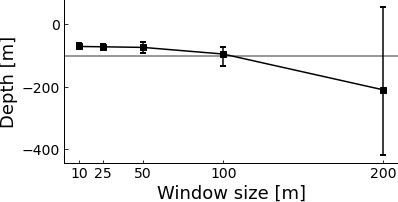

In [731]:
plt.figure(figsize=(6, 3))
bounds_depths = np.vstack([upper_depths - median_depths, median_depths - lower_depths])
plt.errorbar(2 * dxs, median_depths, yerr=bounds_depths, fmt='ks-', capsize=3, capthick=2, label='Dip slip')
xmin, xmax = plt.xlim()
plt.hlines(-100, xmin, xmax, colors='0.6', linestyles='-', lw=2, zorder=-1)
plt.xticks(2 * dxs)
#plt.yticks([0, -250, -500])
plt.xlim([xmin, xmax])
plt.xlabel('Window size [m]')
plt.ylabel('Depth [m]')
plt.savefig(f'/media/rmsare/data/fig/hsl_icp/Figure_DSBootstrapDepths.png', dpi=300, bbox_inches='tight')

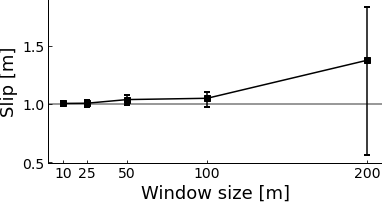

In [732]:
plt.figure(figsize=(6, 3))
bounds_slips = np.vstack([upper_slips - median_slips, median_slips - lower_slips])
plt.errorbar(2 * dxs, median_slips, yerr=bounds_slips, fmt='ks-', capsize=3,  capthick=2, label='Dip slip')
xmin, xmax = plt.xlim()
plt.hlines(1, xmin, xmax, colors='0.6', linestyles='-', lw=2, zorder=-1)
plt.xticks(2 * dxs)
plt.xlabel('Window size [m]')
plt.ylabel('Slip [m]')
plt.xlim([xmin, xmax])
plt.savefig(f'/media/rmsare/data/fig/hsl_icp/Figure_DSBootstrapSlipss.png', dpi=300, bbox_inches='tight')

## Strike slip

In [418]:
us = np.load('profiles/lidar_ss_applied.npy', allow_pickle=True)
uicps = np.load('profiles/lidar_ss_observed.npy', allow_pickle=True)

[-2.70221884e+04  1.10435410e+01]
[-2.80734417e+04  1.04480883e+01]
[-2.68600446e+04  1.30275582e+01]
[-2.52931165e+04  1.72228255e+01]
[-24204.0504666      26.86338043]


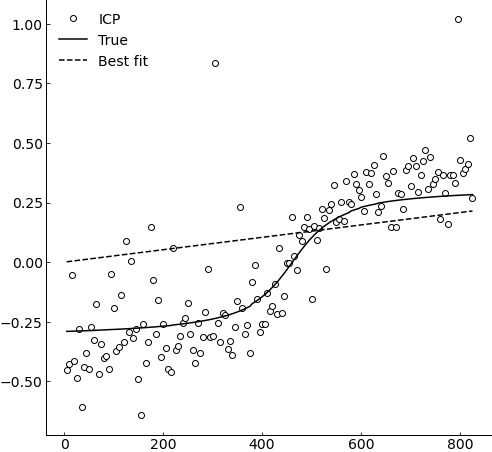

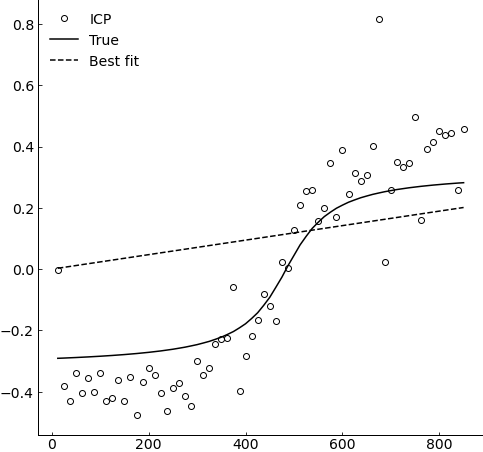

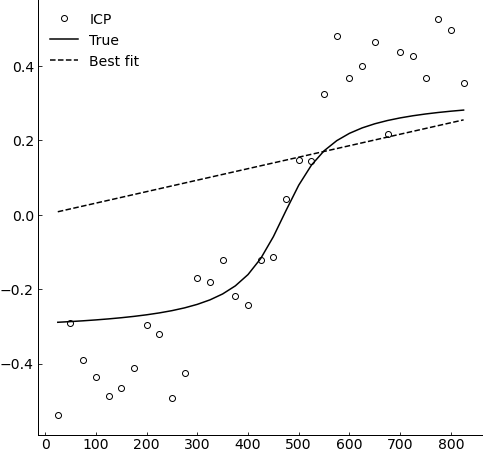

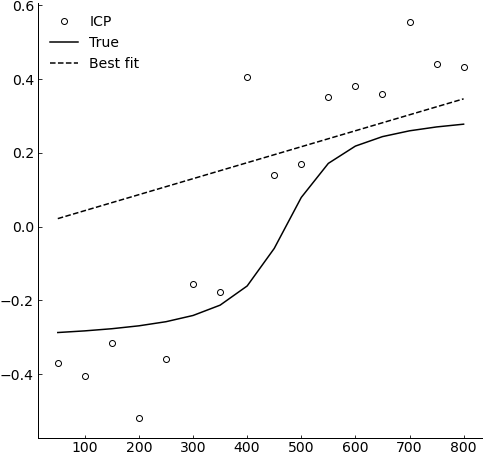

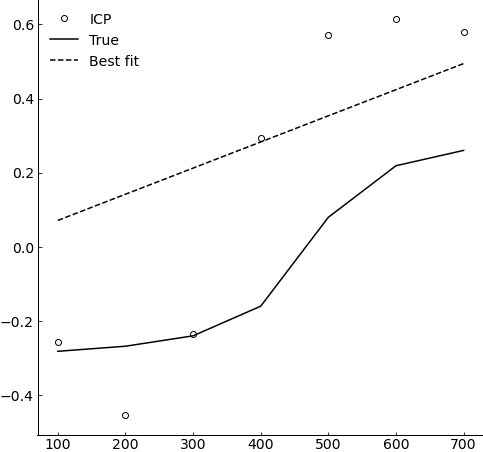

In [430]:
for uobs, utrue, dx in zip(uicps, us, dxs):
    xp, uobsc, utruec = center_profiles(-uobs, utrue, dx=dx)
    x = dx * np.arange(1, len(uobs) + 1)
    phat, pcov = curve_fit(model_1d, x, -uobs)
    uhat = model_1d(x, *phat)
    print(phat)

    plt.figure()
    plt.plot(x, -uobs, 'wo', mec='k', label='ICP')
    plt.plot(x, utrue, 'k-', label='True')
    plt.plot(x, uhat, 'k--', label='Best fit')
    plt.legend()

IndexError: arrays used as indices must be of integer (or boolean) type

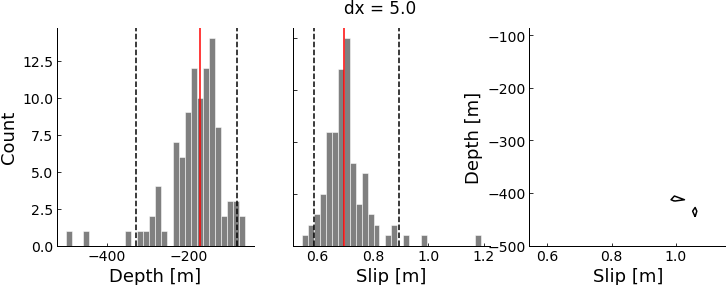

In [422]:
median_depths = []
median_slips = []
upper_depths = []
upper_slips = []
lower_depths = []
lower_slips = []

for uobs, utrue, dx in zip(uicps, us, dxs):
    xp, uobsc, utruec = center_profiles(-uobs, utrue, dx=dx)
    depths_b, slips_b = get_bootstrap_dists(xp, uobsc, nboot=100, p0=[-1, 0.1], bounds=([-500, 0.1], [-1, 10]))
    median_depths.append(np.nanmedian(depths_b))
    median_slips.append(np.nanmedian(slips_b))
    upper_depths.append(np.nanpercentile(depths_b, 97.5))
    upper_slips.append(np.nanpercentile(slips_b, 97.5))
    lower_depths.append(np.nanpercentile(depths_b, 2.5))
    lower_slips.append(np.nanpercentile(slips_b, 2.5))
    plot_bootstrap_dists(depths_b, slips_b)
    plt.suptitle(f'dx = {dx:.1f}')

dxs = np.array(dxs)
median_depths = np.array(median_depths)
median_slips = np.array(median_slips)
upper_depths = np.array(upper_depths)
lower_depths = np.array(lower_depths)
upper_slips = np.array(upper_slips)
lower_slips = np.array(lower_slips)

In [ ]:
plt.figure(figsize=(6, 3))
bounds_depths = np.vstack([upper_depths - median_depths, median_depths - lower_depths])
plt.errorbar(2 * dxs, median_depths, yerr=bounds_depths, fmt='ks-', capsize=3, capthick=2, label='Dip slip')
xmin, xmax = plt.xlim()
plt.hlines(-100, xmin, xmax, colors='0.6', linestyles='-', lw=2, zorder=-1)
plt.xticks(2 * dxs)
#plt.yticks([0, -250, -500])
plt.xlim([xmin, xmax])
plt.xlabel('Window size [m]')
plt.ylabel('Depth [m]')

In [ ]:
plt.figure(figsize=(6, 3))
bounds_slips = np.vstack([upper_slips - median_slips, median_slips - lower_slips])
plt.errorbar(2 * dxs, median_slips, yerr=bounds_slips, fmt='ks-', capsize=3,  capthick=2, label='Dip slip')
xmin, xmax = plt.xlim()
plt.hlines(1, xmin, xmax, colors='0.6', linestyles='-', lw=2, zorder=-1)
plt.xticks(2 * dxs)
plt.xlabel('Window size [m]')
plt.ylabel('Slip [m]')
plt.xlim([xmin, xmax])
